# Use REBOUND commit 361adacb48ff55ea8331adbf37a943e63ca02984 on oldMLstability branch

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import rebound
import dask.dataframe as dd
plt.style.use('paper')

In [2]:
csvpath = '../csvs/random/random_features/'
distpath = '../../stabilitydataset/data/random/initial_conditions/runs/'
df = pd.read_csv(csvpath + 'distributionfeaturesnew.csv', index_col=0)
df = df[['ID', 'Mean', 'Sigma', 'KSpval']]
df.head()

,ID,Mean,Sigma,KSpval
0,1007,5.587629,0.464593,6.663128e-02
1,1021,6.003999,0.327314,5.287958e-01
2,1025,5.794418,0.385985,4.101035e-02
3,1041,5.730234,0.494415,8.813668e-07
4,10518,6.465849,0.431597,6.504852e-03


In [3]:
df.shape

(248, 4)

In [4]:
df = df[(df['Mean'] > 4) & (df['Mean'] < 7)]
df.shape

(244, 4)

In [5]:
labels = pd.read_csv('../../MLstability/training_data/random/labels.csv', index_col=0)
labels.head()

,runstring,instability_time,shadow_instability_time,Stable
0,0000000.bin,1.235665e+07,8.315223e+07,False
1,0000001.bin,1.348749e+05,2.133072e+05,False
2,0000002.bin,1.276428e+04,9.321863e+03,False
3,0000003.bin,1.000000e+09,1.000000e+09,True
4,0000004.bin,8.791890e+01,8.791890e+01,False


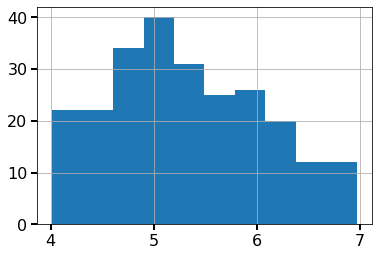

In [6]:
df['Mean'].hist()

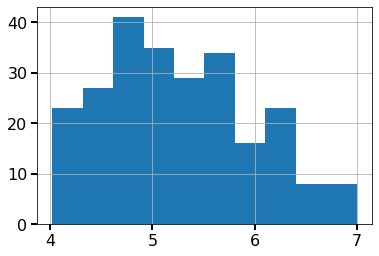

In [7]:
np.log10(labels.loc[df['ID']]['instability_time']).hist()

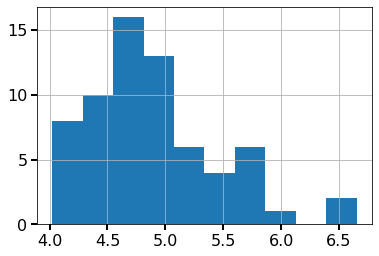

In [8]:
np.log10(labels.loc[df[df['KSpval'] < 1.e-6]['ID']]['instability_time']).hist()

In [104]:
def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

def run(row):
    tmax = 1e7
    ID = int(row['ID'])
    
    file = distpath+"ic{0:0=7d}.bin".format(ID)
    sim = rebound.Simulation.from_file(file)
    sim.ri_whfast.keep_unsynchronized = 1
    sim.collision_resolve=collision
    sim.init_megno(seed=0)
    
    Nout = 1000
    times = np.logspace(0, np.log10(tmax), Nout)
    P0 = sim.particles[1].P
    megnos, tlyaps = np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        if sim._status == 5:
            break
        megnos[i] = sim.calculate_megno()
        tlyaps[i] = 1/sim.calculate_lyapunov()/P0
        
    nonzero = int((megnos > 0).sum())
    megnos = megnos[:nonzero]
    tlyaps = tlyaps[:nonzero]
    row['tlyap'] = tlyaps[~np.isnan(tlyaps)][-1]
    if row['tlyap'] < 0 or row['tlyap'] > sim.t:
        row['tlyap'] = sim.t
    row['megno'] = megnos[~np.isnan(megnos)][-1]
    row['megnonan'] = np.isnan(megnos[-1])
    row['instability_time'] = labels.loc[ID, 'instability_time']
    row['Nlyap'] = row['instability_time']  / row['tlyap']
    return row

def runsplit(row):
    tmax = 1e7
    ID = int(row['ID'])
    row['instability_time'] = labels.loc[ID, 'instability_time']

    file = distpath+"ic{0:0=7d}.bin".format(ID)
    sim = rebound.Simulation.from_file(file)
    sim.ri_whfast.keep_unsynchronized = 1
    sim.collision_resolve=collision
    sim.init_megno(seed=0)

    Nout = 1000
    times = np.logspace(0, np.log10(tmax), Nout)
    P0 = sim.particles[1].P

    sim.integrate(row['instability_time']/10, exact_finish_time=0)
    row['tlyap10'] = 1/sim.calculate_lyapunov()/P0
    if row['tlyap10'] < 0 or row['tlyap10'] > sim.t:
        row['tlyap10'] = sim.t
    row['megno10'] = sim.calculate_megno()
    row['Nlyap10'] = row['instability_time']  / row['tlyap10']
    
    sim.integrate(row['instability_time']/5, exact_finish_time=0)
    row['tlyap5'] = 1/sim.calculate_lyapunov()/P0
    if row['tlyap5'] < 0 or row['tlyap5'] > sim.t:
        row['tlyap5'] = sim.t
    row['megno5'] = sim.calculate_megno()
    row['Nlyap5'] = row['instability_time']  / row['tlyap5']

    sim.integrate(row['instability_time']/3, exact_finish_time=0)
    row['tlyap3'] = 1/sim.calculate_lyapunov()/P0
    if row['tlyap3'] < 0 or row['tlyap3'] > sim.t:
        row['tlyap3'] = sim.t
    row['megno3'] = sim.calculate_megno()
    row['Nlyap3'] = row['instability_time']  / row['tlyap3']
    return row

# We don't get exactly the same instability time when rerunning stopping along the way because the original integrations are using unsynced positions to detect collisions and megno syncs them. But that's fine. We always get very close, because it's once the orbits are crossing that we start finding collisions (synced or unsynced). This is a demonstration that the exact details of detecting collisions doesn't matter. We've also already checked reproducibility when we do a single sim.integrate (see test_notebooks) and here we just want the lyap times

In [98]:
row = df.loc[0]
tmax = 1e7
ID = int(row['ID'])
row['instability_time'] = labels.loc[ID, 'instability_time']

file = distpath+"ic{0:0=7d}.bin".format(ID)
sim = rebound.Simulation.from_file(file)
sim.ri_whfast.keep_unsynchronized = 1
sim.collision_resolve=collision
sim.init_megno(seed=0)

Nout = 1000
times = np.logspace(0, np.log10(tmax), Nout)
P0 = sim.particles[1].P

sim.integrate(row['instability_time']/10, exact_finish_time=0)
row['tlyap10'] = 1/sim.calculate_lyapunov()/P0
if row['tlyap10'] < 0 or row['tlyap10'] > sim.t:
    row['tlyap10'] = sim.t
row['megno10'] = sim.calculate_megno()
row['Nlyap10'] = row['instability_time']  / row['tlyap10']

sim.integrate(row['instability_time']/3, exact_finish_time=0)
row['tlyap3'] = 1/sim.calculate_lyapunov()/P0
if row['tlyap3'] < 0 or row['tlyap3'] > sim.t:
    row['tlyap3'] = sim.t
row['megno3'] = sim.calculate_megno()
row['Nlyap3'] = row['instability_time']  / row['tlyap3']

sim.t/P0

58014.27969501363

In [99]:
labels.loc[ID, 'instability_time']

174039.58282690134

# Generate

In [ ]:
%%time
ddf = dd.from_pandas(df, npartitions=24)
testres = runsplit(df.iloc[0])
df = ddf.apply(runsplit, axis=1, meta=pd.DataFrame([testres])).compute(scheduler='processes')

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:374: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/s

In [ ]:
df.to_csv(csvpath+'random1e7featuressplit.csv')

In [102]:
row = df.loc[3]
tmax = 1e7
ID = int(row['ID'])
tmax = labels.loc[ID, 'instability_time']#/10.

file = distpath+"ic{0:0=7d}.bin".format(ID)
sim = rebound.Simulation.from_file(file)
sim.ri_whfast.keep_unsynchronized = 1
sim.collision_resolve=collision
sim.init_megno(seed=0)

Nout = 1000
times = np.logspace(0, np.log10(tmax), Nout)
P0 = sim.particles[1].P
megnos, tlyaps = np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    sim.integrate(time, exact_finish_time=0)
    if sim._status == 5:
        break
    megnos[i] = sim.calculate_megno()
    tlyaps[i] = 1/sim.calculate_lyapunov()/P0

nonzero = int((megnos > 0).sum())
megnos = megnos[:nonzero]
tlyaps = tlyaps[:nonzero]
row['tlyap'] = tlyaps[~np.isnan(tlyaps)][-1]
if row['tlyap'] < 0 or row['tlyap'] > sim.t:
    row['tlyap'] = sim.t
row['megno'] = megnos[~np.isnan(megnos)][-1]
row['megnonan'] = np.isnan(megnos[-1])
row['instability_time'] = labels.loc[ID, 'instability_time']
row['Nlyap'] = row['instability_time']  / row['tlyap']
sim.t/P0

/home/dtamayo/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


714412.3112341705

Text(0, 0.5, 'megno')

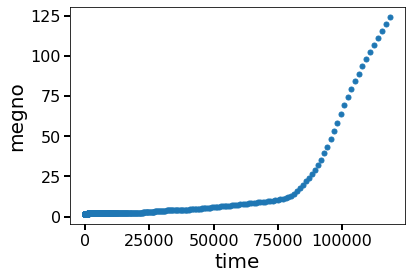

In [108]:
fig, ax = plt.subplots()
ax.plot(times[:nonzero], megnos, '.')
ax.set_xlabel('time')
ax.set_ylabel('megno')

In [105]:
runsplit(df.loc[3])

ID                  1.041000e+03
Mean                5.730234e+00
Sigma               4.944148e-01
KSpval              8.813668e-07
tlyap               1.248293e+03
megno               1.243959e+02
Nlyap               5.656824e+02
instability_time    7.144123e+05
megnonan            0.000000e+00
tlyap10             9.095502e+03
megno10             9.486404e+00
Nlyap10             7.854567e+01
tlyap5                       NaN
megno5                       NaN
Nlyap5                       NaN
tlyap3                       NaN
megno3                       NaN
Nlyap3                       NaN
Name: 3, dtype: float64